# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score#, plot_confusion_matrix
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [5]:
PATH = "./data/"

In [6]:
data = pd.read_csv(os.path.join(PATH, 'train.csv')).set_index('PassengerId')

In [7]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [8]:
temp = data['Sex'].value_counts().rename('cnt').to_frame()
temp['%'] = (data['Sex'].value_counts(normalize=True) * 100).round(2)
temp.index.name = 'Sex'
temp

,cnt,%
Sex,,
male,577,64.76
female,314,35.24


In [9]:
temp = data['Survived'].value_counts().rename('cnt').to_frame()
temp['%'] = (data['Survived'].value_counts(normalize=True) * 100).round(2)
temp.index.name = 'Survived'
temp

,cnt,%
Survived,,
0,549,61.62
1,342,38.38


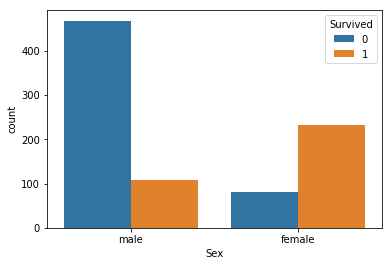

In [10]:
sns.countplot(data=data, x='Sex', hue='Survived');

По грфику видно, что женщин и в абсолютных и в относительных числах выжило больше, чем мужчин.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

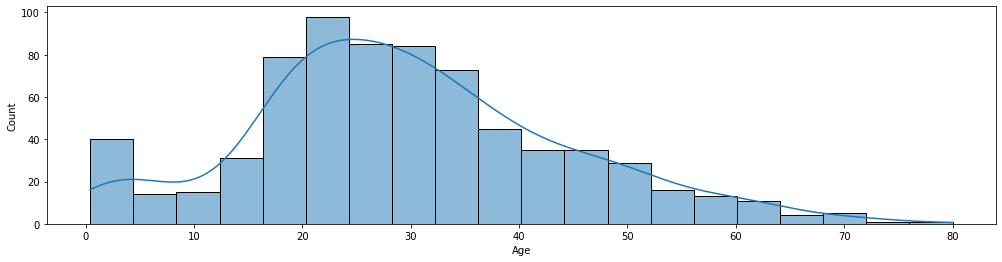

In [9]:
plt.figure(figsize=(17,4))
sns.histplot(data=data, x='Age', kde=True);

In [11]:
data.groupby('Survived')['Age'].agg(['mean', 'median'])

,mean,median
Survived,,
0,30.626179,28.0
1,28.343690,28.0


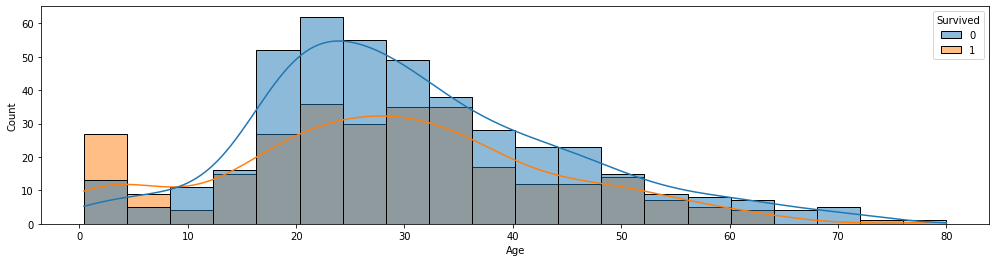

In [11]:
plt.figure(figsize=(17,4))
sns.histplot(data=data, x='Age', hue='Survived', kde=True);

Форма распределения выживших похожа на таковую для погибших. Но колокол ниже по высоте, поскольку выживших меньше чем погибших. Т.е. можно сказать, что в среднем люди равномерно погибали для каждой возростной группы. Отдельно выделяются дети до 10 лет - у них больше выживших чем погибших. Наверное им отдавали приоритет в спасательных шлюпках. Также практически нет выживших старше 65 лет. но их в целом мало, чтобы делать какие-то выводы.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

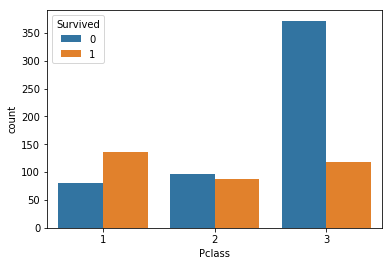

In [12]:
sns.countplot(data=data, x='Pclass', hue='Survived');

В абсолютных числах число выживших примерно одинаковое между классами. Но в относительном исчислении больше всего выживших выше в первом классе (выжевших даже больше чем погибших). Хуже всего дела обстоят в третьем классе - в нем погибших сильно больше выживших. Возможно это связано с тем, что каюты третьего класса распологались на нижних палубах (и добраться до шлюпок им было сложнее), либо же места в шлюпках им выделялись в последнюю очередь.

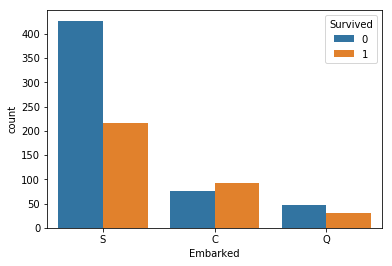

In [13]:
sns.countplot(data=data, x='Embarked', hue='Survived');

Embarked это пункт посадки пассажиров. На первый взгляд он не должен влиять на статистику выживаемости. Но между пунктами явно наблюдается дисбаланс: в абсолютных числах больше всего выживших из пункта S, а в относительных из пункта C. Можно предположить, что пункт S - это начальная точка отправления Титаника и там больше всего пассажиров село на борт. В портах С и Q пассажиров добрали. Если посмотреть, на посадку классов, по пунктам посадки, то видно что в C село много пассажиров первого класса, чем и объясняется выживаемость пассажиров из пункта C. Возможно C это какой-то богатый город, где много людей могут себе позволить билет первого класса:

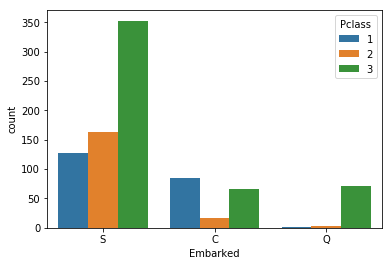

In [14]:
sns.countplot(data=data, x='Embarked', hue='Pclass');

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [15]:
temp = data.isna().sum().sort_values(ascending=False).rename('null_cnt').to_frame()
temp['%'] = (data.isna().mean()*100).round(2)
temp.index.name = 'column'
temp

,null_cnt,%
column,,
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22
Fare,0,0.00
Ticket,0,0.00
Parch,0,0.00
SibSp,0,0.00
Sex,0,0.00
Name,0,0.00


Ну и сделаем это красиво :)

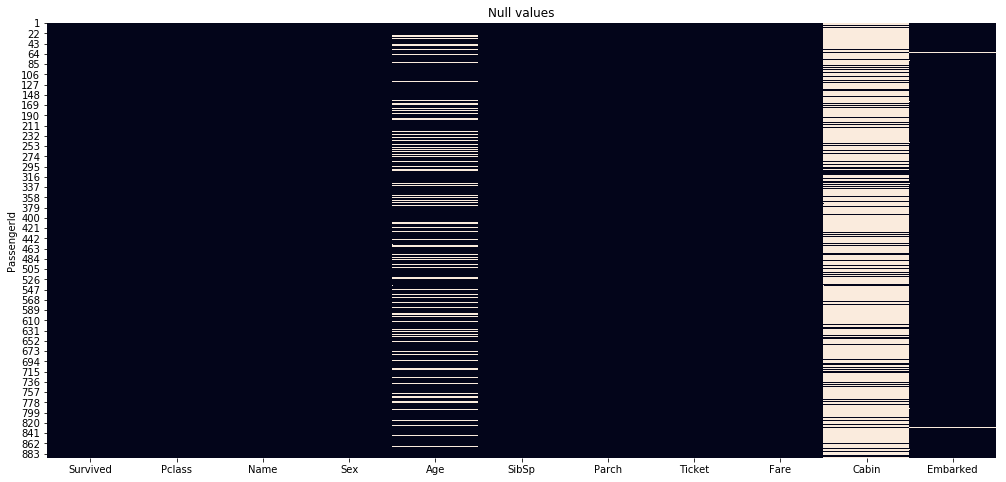

In [16]:
plt.figure(figsize=(17,8))
sns.heatmap(data.isnull(), cbar = False).set_title('Null values');

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

1. Лучше всего использовать модель, которые из коробки могут работать с пропусками (LGBM или Catboost) - они сами с ними разберутся, а потом красиво отобразят в каком-нибудь SHAP.
2. Если для линеек и пр. (которые не умеют работать с пропусками по определению), то:
 - Cabin я бы вовсе удалил, слишком много пропусков.
 - Age я бы попробовал заполнить с помощью какой либо другой модели. Либо попрбовал один из типовых ипутеров - какой-лучше бы показал себя, тот бы и оставил.
 - Embarked - медианой - пропусков слишком мало, погоды это не сделет.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [17]:
y = data['Survived']
X = data[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']].copy()
X['Sex'] = X['Sex'].map({'male':0,'female':1})
X = pd.get_dummies(X, columns = ['Embarked'])
X = X.fillna(X.median())

X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,
1,3,0,22.0,1,0,7.2500,0,0,1
2,1,1,38.0,1,0,71.2833,1,0,0
3,3,1,26.0,0,0,7.9250,0,0,1
4,1,1,35.0,1,0,53.1000,0,0,1
5,3,0,35.0,0,0,8.0500,0,0,1


In [33]:
pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier())
score = cross_val_score(pipeline, X, y, scoring='accuracy', cv=3)
score = np.array(score)
print(score.round(2), '~', round(score.mean(),2))

[0.79 0.79 0.8 ] ~ 0.79


In [19]:
score = cross_val_score(LogisticRegression(max_iter=500), X, y, scoring='accuracy', cv=3)
score = np.array(score)
print(score.round(2), '~', round(score.mean(),2))

[0.79 0.79 0.79] ~ 0.79


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Лучший скор на Кэгле - **0.79186**. Ник на Кэгле - slivka83.

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.79 \leq score < 0.81,$$
$$ f(score) = 1.0, \ \ 0.81 \leq score < 0.83,$$ 
$$ f(score) = 2.5, \ \ 0.83 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

решение:
https://github.com/slivka83/share/blob/master/titanic-0.79186.ipynb

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [17]:
insurance_data = pd.read_csv('porto/train.csv').set_index('id')

In [18]:
print(insurance_data.shape)
insurance_data.head()

(595212, 58)


,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [19]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [20]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
clf = pipeline.fit(X_train, y_train)

/opt/python3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/python3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


We'll calculate the model accuracy:

In [23]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

/opt/python3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

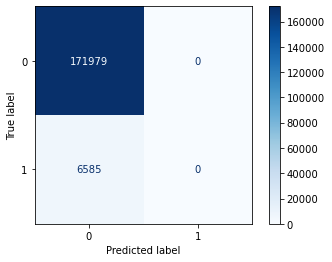

In [21]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [24]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

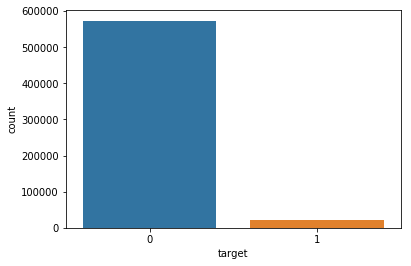

In [25]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [26]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

Коэффициент Джини начал свою историю в экономике и уже затем перебрался в машинное обучение притерпев некоторые изменения. 
Все эти изменения описывать не будем, а дадим сразу определенеие Коэффициент Джини в машинном обучении:
Численно коэффициент Джини равен площади фигуры между главной диагональю и кривой модели (ROC кривой).

Таким образом коэффициент Джини графичеки можно отобарзить следующим образом:
<img src="https://raw.githubusercontent.com/slivka83/share/master/pic1.png" height=150 width=150>

Сам по себе коэффициент Джини не очень информативен (0.204 это много или мало?) поэтому метрикой качества в машинном обучении является нормализованный коэффициент Джини (обычно именно его в машинном обучении называют Коэффициент Джини), который равен отношению коэффициента Джини к площади идеальной модели.

А как мы знаем в пространстве ROC кривой идеальная модель проходит через точки (0,0), (0,1) и (1,1), а ее площадь равна верхнему левему треугольнику.
<img src="https://raw.githubusercontent.com/slivka83/share/master/pic2.png" height=150 width=150>

Таким образом нормализованный коэффициент Джини равен: 

$$normGini = \frac{A}{A + B}$$

$A+B$ в пространстве ROC кривой занимет площадь ровную $1/2$. А значит нормализованный коэффициент Джини можно записать как:

$$normGini = \frac{A}{1/2} = 2*A$$

ROC AUC это площадь под кривой и через коэффициент Джини ее можно записать как:
<img src="https://raw.githubusercontent.com/slivka83/share/master/pic3.png" height=150 width=150>

$$ROC AUC = A + 1/2$$

Проведя нехитрые преобразования запишим нормализованный коэффициент Джини через ROC AUC:

$$A = ROC AUC - 1/2$$
$$normGini = 2*A = 2 * (ROC AUC - 1/2) = 2*ROC AUC - 1$$

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

Для несбалансированного датасета главное не брать Accuracy. В остальном достаточно много метрик, которые более-менее устойчивы к дисбалансу кассов, но обладают различными свойствами. И их выбор в большей степени обусловлен бизнес-задачей:
- Precision
- Recall
- F1
- AUC-ROC
- AUC-PR

Конкретно для этого случая, если не Джини, то я бы взял ROC AUC, потому-то по сути это тоже самое, только в другом масштабе.

Let's calculate the Normalized Gini Coefficient:

In [27]:
y_pred = clf.predict_proba(X_valid)[:, 1]

/opt/python3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [28]:
gini_normalized(y_valid, y_pred)

0.25652185561929747

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

Ноутбук с решением: https://github.com/slivka83/share/blob/master/porto_send_1.ipynb

Лучший скор - **0.27430**

In [1]:
round(200*max(0.27430 - 0.253,0))/2

2.0